In [125]:
# Dependencies:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
from config import api_key
from pprint import pprint
import requests
import math
import seaborn as sns


In [ ]:
# Data 
# global netflix data from netflix.com top 10 weekly shows
global_netflix_df = pd.read_csv("Resources/all-weeks-global.csv")
global_netflix_df.head()
global_netflix_df.dtypes

# Netflix Title data from kaggle.com- has title, info, imdb ratings, etc.
titles_netflix_df = pd.read_csv("Resources/titles.csv")
titles_netflix_df.head()
titles_netflix_df.dtypes

# Merge 
global_titles_df = pd.merge(global_netflix_df, titles_netflix_df, how= "left", left_on="show_title", right_on="title")
global_titles_df.drop(["title","tmdb_popularity","tmdb_score"], axis=1, inplace=True)
global_titles_df

In [206]:
url = "http://www.omdbapi.com/?t="
api_key = f"&apikey={api_key}"

In [ ]:
# Changing all NAN values to NA in global_titles_df for easy referencing 
df = global_titles_df.fillna("NA")
df
# filtering data where imdb_score is NA and respective show title
df1 = df.loc[df["imdb_score"]=="NA","show_title"]
# Created the movie list with unique movie/show names
movies_list = df1.unique().tolist()
# Total number of unique movies/shows
len(movies_list)

In [ ]:
# List that has unique movie/show names
movies_list
# Empty list to store fetched data from API
data = []
# API Key
api_key = f"&apikey={api_key}"
# looping through the movie list and fetching data for each movie
for movie in movies_list:
    try:
        response = requests.get(url+movie+api_key).json()
        # Appending data to the list
        data.append({"show_title":response["Title"],
                    "id" :response["imdbID"],"type":response["Type"],"description":response["Plot"],
                    "release_year":response["Year"],"age_certification":response["Rated"],"runtime":response["Runtime"],
                    "genres":response["Genre"],"production_countries":response["Country"],"imdb_id":response["imdbID"],
                    "imdb_score":response["imdbRating"],"imdb_votes":response["imdbVotes"]})
    except KeyError:
        pass

In [ ]:
# Converting the data fetched from API in to the dataframe
df3 = pd.DataFrame(data)
df3
# Exporting data fetched from the API to csv file
df3.to_csv("output_data/api_data.csv")

In [ ]:
# merged the data fetched from API DF(df3) with the dataframe we hav(global_titles_df)
#changing all show titles into lower case 
global_titles_df["Show_title"]=global_titles_df['show_title'].str.lower()
df3["Show_title"]=df3['show_title'].str.lower()

merge_df = pd.merge(global_titles_df, df3, how= "left",on="Show_title")
# combining the data and storing it in separate column.(eg:combined type_x,type_y into one column type) and data cleaning
combined_df = merge_df.assign(type=merge_df.type_x.fillna(merge_df.type_y))
combined_df = combined_df.assign(description=merge_df.description_x.fillna(merge_df.description_y))
combined_df = combined_df.assign(release_year=merge_df.release_year_x.fillna(merge_df.release_year_y))
combined_df = combined_df.assign(age_certification=merge_df.age_certification_x.fillna(merge_df.age_certification_y))
combined_df = combined_df.assign(runtime=merge_df.runtime_x.fillna(merge_df.runtime_y))
combined_df = combined_df.assign(genres=merge_df.genres_x.fillna(merge_df.genres_y))
combined_df = combined_df.assign(production_countries=merge_df.production_countries_x.fillna(merge_df.production_countries_y))
combined_df = combined_df.assign(imdb_id=merge_df.imdb_id_x.fillna(merge_df.imdb_id_y))
combined_df = combined_df.assign(imdb_score=merge_df.imdb_score_x.fillna(merge_df.imdb_score_y))
combined_df = combined_df.assign(imdb_votes=merge_df.imdb_votes_x.fillna(merge_df.imdb_votes_y))
#dropping used columns
combined_df.drop(["show_title_x","show_title_y","id_x","id_y","type_x","type_y","description_x","description_y","release_year_x",
                "release_year_y","age_certification_x","age_certification_y","runtime_x","runtime_y","genres_x","genres_y",
                "production_countries_x","production_countries_y","imdb_id_x","imdb_id_y","imdb_score_x","imdb_score_y",
                "imdb_votes_x","imdb_votes_y","season_title","seasons"], axis=1, inplace=True)
#dropped all rows that has NAN values 
combined_df = combined_df.dropna()
# Dropped all rows that has imdb_score equal to N/A
cleaned_df = combined_df.loc[combined_df["imdb_score"]!="N/A"]
cleaned_df = combined_df.loc[combined_df["runtime"]!="N/A"]
cleaned_df = combined_df.loc[combined_df["age_certification"]!="N/A"]
#saving the dataframe into csv file
cleaned_df.to_csv("output_data/cleaned_netflix_data.csv")
print(cleaned_df.count())
cleaned_df

In [ ]:
netflix_df = pd.read_csv("output_data/cleaned_netflix_data.csv")
netflix_df.head()


In [ ]:
# plt.figure(figsize=(8,8))
# plt.scatter(netflix_df["release_year"],netflix_df["imdb_score"])
# plt.grid()
# plt.xlabel("")
# plt.xlim(1990,2024)

In [ ]:
# avg_ratings_per_year = netflix_df.groupby("release_year").mean()["imdb_score"]
# median_ratings_per_year = netflix_df.groupby("release_year").median()["imdb_score"]
# plt.figure(figsize=(20,5))
# plt.plot(avg_ratings_per_year.index,avg_ratings_per_year.values,label="mean",color="blue")
# plt.plot(median_ratings_per_year.index,median_ratings_per_year.values,label="median",color="red")
# plt.legend(loc="lower right")
# plt.xlabel("Year Released", fontsize=16)
# plt.ylabel("Average Ratings", fontsize=16)
# plt.title("Average Rating (vs) Year Of Release",fontsize=16)
# plt.xlim(1990,2024)
# plt.ylim(5,9)
# plt.grid(color="green", alpha=.5)


In [ ]:
# # plt.bar(x, y1, color='r')
# # plt.bar(x, y2, bottom=y1, color='b')
# # plt.bar(x, y3, bottom=y1+y2, color='y')
# # plt.bar(x, y4, bottom=y1+y2+y3, color='g')
# #colors = ["Red","Orange","Orange","Yellow","Yellow","Green","Yellow","Orange","Yellow","Orange"]
# #colors = ["Red","Orange","Yellow","Green","blue","purple","Indigo","pink","darkblue","violet"]
# # Films_English = rank_df.loc[rank_df["category"]=="Films (English)",rank_df["cumulative_weeks_in_top_10"]]
# # Films_Non_English= rank_df.loc[rank_df["category"]=="Films (Non-English)",rank_df["cumulative_weeks_in_top_10"]]
# # TV_English = rank_df.loc[rank_df["category"]=="TV (English)",rank_df["cumulative_weeks_in_top_10"]]
# # TV_Non_English = rank_df.loc[rank_df["category"]=="TV (Non-English)",rank_df["cumulative_weeks_in_top_10"]]

# Films_English = rank_df.groupby(rank_df["category"]).count()["cumulative_weeks_in_top_10"]

# plt.bar(rank_df["weekly_rank"],Films_English,color = 'r')

# plt.bar(rank_df["weekly_rank"],Films_Non_English,bottom=Films_English, color="green")

# plt.bar(rank_df["weekly_rank"],TV_English,bottom=Films_English+Films_Non_English, color="blue")

# plt.bar(rank_df["weekly_rank"],TV_Non_English,bottom = Films_English+Films_Non_English+TV_Non_English, color="pink")


# plt.xlabel("Weekly Rank")
# plt.ylabel("Cumulative Weeks In Top 10")

In [ ]:
# plt.bar(rank_df["weekly_rank"],rank_df["cumulative_weeks_in_top_10"],color="green")
# plt.xlabel("Weekly Rank")
# plt.ylabel("Cumulative Weeks In Top 10")
# plt.show()

In [210]:
netflix_df["imdb_score"]= netflix_df["imdb_score"].astype(str)
netflix_df.loc[netflix_df["imdb_score"]=="nan"].count()["imdb_score"]
netflix_df["imdb_score"] = netflix_df["imdb_score"].replace("nan", "0")
netflix_df["imdb_score"]= netflix_df["imdb_score"].astype(float)
# imdb_score
netflix_df["imdb_votes"]= netflix_df["imdb_votes"].astype(str)
netflix_df.loc[netflix_df["imdb_votes"]=="nan"].count()["imdb_votes"]
netflix_df["imdb_votes"] = netflix_df["imdb_votes"].replace("nan", "0")
netflix_df["imdb_votes"]= netflix_df["imdb_votes"].astype(float)
netflix_df
# Reading from CSV
netflix_df = pd.read_csv("output_data/cleaned_netflix_data.csv")
netflix_df.to_csv("output_data/cleaned_netflix_data.csv")

netflix_df.head()

,Unnamed: 0,week,category,weekly_rank,weekly_hours_viewed,cumulative_weeks_in_top_10,Show_title,type,description,release_year,...,production_countries,imdb_id,imdb_score,imdb_votes,drama,comedy,action,family,crime,romance
0,0,2022-10-30,Films (English),1,68310000,1,the good nurse,movie,An infamous caregiver is implicated in the dea...,2022,...,United States,tt4273800,7.1,204.0,1,0,0,0,1,0
1,1,2022-10-30,Films (English),2,41950000,2,the school for good and evil,movie,Best friends Sophie and Agatha find themselves...,2022,...,United States,tt2935622,5.8,18952.0,1,1,1,0,0,0
2,2,2022-10-30,Films (English),3,9170000,2,the stranger,SHOW,A web of secrets sends family man Adam Price o...,2020,...,United Kingdom,tt9698480,7.3,48298.0,1,0,0,0,1,0
3,3,2022-10-30,Films (English),4,8890000,1,wild is the wind,movie,An immigrant Nevada rancher brings a woman fro...,1957,...,United States,tt0051193,6.7,1027.0,1,0,0,0,0,0
4,4,2022-10-30,Films (English),5,8170000,3,the curse of bridge hollow,movie,"A teenage girl, who accidentally releases an a...",2022,...,United States,tt15289240,NaN,4085.0,0,1,0,1,0,0


In [35]:
# Grouped by show_title to find top weekly rank per each movie vs cumulative_weeks_in_top_10
groupedby_title = netflix_df.groupby("Show_title").agg({"weekly_rank":"min","cumulative_weeks_in_top_10":"max"}).reset_index()

rank_df = pd.merge(groupedby_title,netflix_df,how="inner",on=["Show_title","weekly_rank","cumulative_weeks_in_top_10"])
rank_df


,Show_title,weekly_rank,cumulative_weeks_in_top_10,week,category,weekly_hours_viewed,type,description,release_year,age_certification,...,production_countries,imdb_id,imdb_score,imdb_votes,drama,comedy,action,family,crime,romance
0,1917,7,1,2022-08-14,Films (English),10840000,movie,"April 6th, 1917. As an infantry battalion asse...",2019,R,...,"United Kingdom, United States, India, Spain",tt8579674,8.2,579698.0,1,0,1,0,0,0
1,21 jump street,6,1,2021-11-07,Films (English),11690000,movie,A pair of underachieving cops are sent back to...,2012,R,...,United States,tt1232829,7.2,556200.0,0,1,1,0,1,0
2,211,6,1,2021-11-14,Films (English),7900000,movie,"While on a routine patrol, an aging cop, his p...",2018,R,...,"United States, Bulgaria",tt4976192,4.4,8489.0,1,0,1,0,0,0
3,42 days of darkness,7,1,2022-05-15,TV (Non-English),9920000,SHOW,"In a town in Chile, a woman leads a frantic se...",2022,TV-MA,...,Chile,tt15090462,6.5,1040.0,1,0,0,0,1,0
4,6 underground,5,3,2022-04-03,Films (English),8730000,MOVIE,"After faking his death, a tech billionaire rec...",2019,R,...,United States,tt8106534,6.1,172083.0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,world trade center,10,1,2021-08-08,Films (English),5050000,movie,Two Port Authority police officers become trap...,2006,PG-13,...,"Germany, United States",tt0469641,6.0,84290.0,1,0,0,0,0,0
308,worth,3,2,2021-09-12,Films (English),13560000,MOVIE,"Kenneth Feinberg, a powerful D.C. lawyer appoi...",2021,PG-13,...,"Canada, United Kingdom, United States",tt8009744,6.8,13524.0,1,0,0,0,0,0
309,yakuza princess,5,1,2022-04-24,Films (English),7490000,movie,The heiress to half of the Yakuza crime syndic...,2021,R,...,Brazil,tt10715446,4.7,1708.0,0,0,0,0,0,0
310,yeh kaali kaali ankhein,6,1,2022-01-23,TV (Non-English),11260000,SHOW,Relentlessly pursued by a powerful politician’...,2022,TV-MA,...,India,tt14160712,7.0,7569.0,1,0,0,0,1,0


In [38]:
weekly_rank = rank_df.iloc[:,1]
cumulative_weeks_in_top_10 = rank_df.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")

correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.38


In [46]:
#Films (English)
films_english = rank_df.loc[rank_df["category"]=="Films (English)"]
weekly_rank = films_english.iloc[:,1]
cumulative_weeks_in_top_10 = films_english.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")


correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.33


In [44]:
#TV_Non_English
TV_Non_English = rank_df.loc[rank_df["category"]=="TV (Non-English)"]
weekly_rank = TV_Non_English.iloc[:,1]
cumulative_weeks_in_top_10 = TV_Non_English.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")


correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.66


In [45]:
#TV_English
TV_English = rank_df.loc[rank_df["category"]=="TV (English)"]
weekly_rank = TV_English.iloc[:,1]
cumulative_weeks_in_top_10 = TV_English.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")


correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.22


In [49]:
# Films_Non_English
Films_Non_English = rank_df.loc[rank_df["category"]=="Films (Non-English)"]
weekly_rank = Films_Non_English.iloc[:,1]
cumulative_weeks_in_top_10 = Films_Non_English.iloc[:,2]
correlation = st.pearsonr(weekly_rank,cumulative_weeks_in_top_10)
print(f"correlation between weekly_rank and cumulative_weeks_in_top_10 is {round(correlation[0],2)}")
#Films_Non_English

correlation between weekly_rank and cumulative_weeks_in_top_10 is -0.39


In [59]:
#Films_Non_English
Films_Non_English = rank_df.loc[rank_df["category"]=="Films (Non-English)"]
corr_matrix = Films_Non_English.corr()
# Largest positive corr:
print(corr_matrix.unstack().sort_values().tail(35))
# Largest negative corr:
print(corr_matrix.unstack().sort_values().head(22))

drama                       imdb_score                    0.209514
imdb_score                  drama                         0.209514
imdb_votes                  drama                         0.215612
drama                       imdb_votes                    0.215612
weekly_hours_viewed         imdb_score                    0.217333
imdb_score                  weekly_hours_viewed           0.217333
comedy                      romance                       0.230949
romance                     comedy                        0.230949
runtime (mins)              action                        0.248337
action                      runtime (mins)                0.248337
family                      cumulative_weeks_in_top_10    0.256782
cumulative_weeks_in_top_10  family                        0.256782
runtime (mins)              weekly_hours_viewed           0.266671
weekly_hours_viewed         runtime (mins)                0.266671
cumulative_weeks_in_top_10  comedy                        0.29

In [60]:
#Films_English
Films_English = rank_df.loc[rank_df["category"]=="Films (English)"]
corr_matrix = Films_English.corr()

print(corr_matrix.unstack().sort_values().tail(35))
# Largest negative corr:
print(corr_matrix.unstack().sort_values().head(22))

comedy                      family                        0.139393
family                      comedy                        0.139393
cumulative_weeks_in_top_10  release_year                  0.160976
release_year                cumulative_weeks_in_top_10    0.160976
cumulative_weeks_in_top_10  weekly_hours_viewed           0.182535
weekly_hours_viewed         cumulative_weeks_in_top_10    0.182535
imdb_votes                  weekly_rank                   0.202922
weekly_rank                 imdb_votes                    0.202922
release_year                weekly_hours_viewed           0.209689
weekly_hours_viewed         release_year                  0.209689
imdb_votes                  runtime (mins)                0.225593
runtime (mins)              imdb_votes                    0.225593
comedy                      cumulative_weeks_in_top_10    0.246518
cumulative_weeks_in_top_10  comedy                        0.246518
comedy                      romance                       0.27

In [61]:
#TV (Non-English)
Films_English = rank_df.loc[rank_df["category"]=="TV (Non-English)"]
corr_matrix = Films_English.corr()

print(corr_matrix.unstack().sort_values().tail(35))
# Largest negative corr:
print(corr_matrix.unstack().sort_values().head(22))

drama                       imdb_score                    0.208178
imdb_score                  drama                         0.208178
imdb_votes                  weekly_rank                   0.210537
weekly_rank                 imdb_votes                    0.210537
weekly_hours_viewed         release_year                  0.214922
release_year                weekly_hours_viewed           0.214922
comedy                      imdb_votes                    0.227763
imdb_votes                  comedy                        0.227763
comedy                      imdb_score                    0.249565
imdb_score                  comedy                        0.249565
comedy                      action                        0.269320
action                      comedy                        0.269320
comedy                      romance                       0.274480
romance                     comedy                        0.274480
imdb_score                  runtime (mins)                0.29

In [205]:
# titles showed up in cumulative_weeks_in_top_10 for more than 10 times
weeks_in_top10 = netflix_df.groupby("Show_title").max().sort_values(by="cumulative_weeks_in_top_10",ascending=False).reset_index()

weeks_in_top10 = weeks_in_top10.loc[df["cumulative_weeks_in_top_10"]>=10][["Show_title","category","cumulative_weeks_in_top_10","type","production_countries"]]

weeks_in_top10

,Show_title,category,cumulative_weeks_in_top_10,type,production_countries
0,"yo soy betty, la fea",TV (Non-English),30,series,Colombia
1,squid game,TV (Non-English),20,SHOW,South Korea
2,stranger things,TV (English),19,SHOW,United States
3,manifest,TV (English),19,SHOW,United States
4,extraordinary attorney woo,TV (Non-English),17,SHOW,South Korea
5,hometown cha-cha-cha,TV (Non-English),16,SHOW,South Korea
6,the queen of flow,TV (Non-English),16,SHOW,Columbia
7,alchemy of souls,TV (Non-English),15,SHOW,South Korea
8,money heist,TV (Non-English),14,SHOW,Spain
9,red notice,Films (English),14,MOVIE,United States


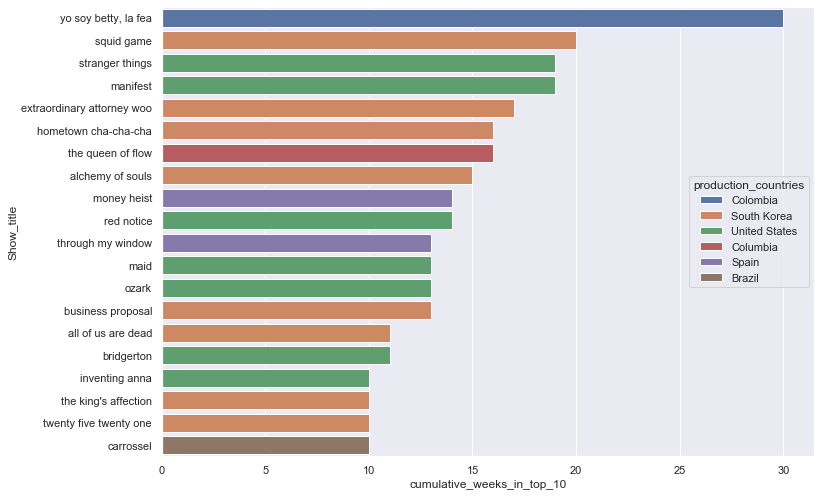

In [188]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.barplot(data=weeks_in_top10, y= "Show_title", x ="cumulative_weeks_in_top_10",hue="production_countries",dodge=False)
sns.move_legend(plot, "center right")

In [184]:
# Netflix hits don't stay popular for long
popularity_fading = netflix_df.groupby("cumulative_weeks_in_top_10").count().sort_values(by="cumulative_weeks_in_top_10").reset_index()
popularity_fading = popularity_fading[["Show_title","cumulative_weeks_in_top_10"]]

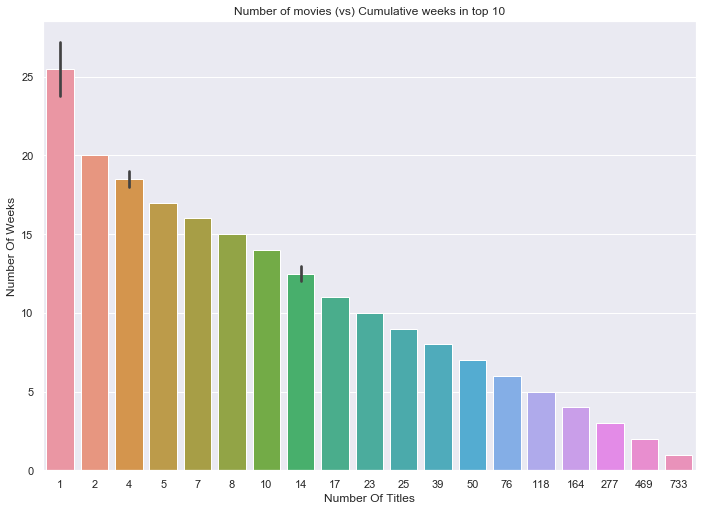

In [208]:
# Bar graph to show how many movies stayed in top for long
ax= sns.barplot(data=popularity_fading, y= "cumulative_weeks_in_top_10", x ="Show_title")
ax.set(xlabel='Number Of Titles', ylabel='Number Of Weeks',title="Number of movies (vs) Cumulative weeks in top 10")
plt.show()
